In [1]:
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Batter Segmentation Analysis

In [2]:
pitcher_data = pd.read_csv('C:/Users/wanns/OneDrive/Desktop/Coding/MSDS/DS6021-Project/data/cleaned/final_pitchers_df.csv')

In [3]:
pitcher_data.head()

,row_id,playerID,year,position,age,avg_salary_year,free_agent_salary,contract_length,W,L,...,E,DP,PB,WP.1,ZR,won_cy_young,won_mvp,won_gold_glove,won_silver_slugger,all_star
0,abbotpa01_2003,abbotpa01,2003,P,36,2.573473e+06,6.000000e+05,1.0,19.0,9.0,...,1.0,3.0,0.0,0.0,NaN,0,0,0,0,0
1,almanar01_2003,almanar01,2003,P,31,2.573473e+06,5.000000e+05,1.0,9.0,9.0,...,1.0,0.0,0.0,0.0,NaN,0,0,0,0,0
2,almoned01_2003,almoned01,2003,P,27,2.573473e+06,NaN,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
3,alvarwi01_2003,alvarwi01,2003,P,33,2.573473e+06,1.500000e+06,1.0,8.0,5.0,...,0.0,2.0,0.0,0.0,NaN,0,0,0,0,0
4,batismi01_2003,batismi01,2003,P,32,2.573473e+06,4.366667e+06,3.0,29.0,26.0,...,5.0,5.0,0.0,0.0,NaN,0,0,0,0,0


In [4]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

In [5]:
# decide what features to use for clustering (initially remove categorical features where distance metrics don't make sense)
X = pitcher_data.select_dtypes(include=['float64', 'int64'])
X.dtypes

year                    int64
age                     int64
avg_salary_year       float64
free_agent_salary     float64
contract_length       float64
W                     float64
L                     float64
G                     float64
GS                    float64
CG                    float64
SHO                   float64
SV                    float64
H                     float64
ER                    float64
HR                    float64
BB                    float64
SO                    float64
IBB                   float64
WP                    float64
HBP                   float64
BK                    float64
BFP                   float64
GF                    float64
R                     float64
SH                    float64
SF                    float64
GIDP                  float64
ERA                   float64
BAOpp                 float64
InnOuts               float64
PO                    float64
A                     float64
E                     float64
DP        

In [6]:
# remove awards and specific defensive stats where distance isn't meaningful for pitching role
drop_cols = ['year', 'free_agent_salary', 'won_cy_young', 'won_mvp', 
             'won_gold_glove', 'won_silver_slugger', 'all_star', 
             'PO', 'A', 'E', 'DP', 'PB', 'ZR', 'WP', 'WP.1', 'BK']
X = X.drop(columns=drop_cols)
X.columns


Index(['age', 'avg_salary_year', 'contract_length', 'W', 'L', 'G', 'GS', 'CG',
       'SHO', 'SV', 'H', 'ER', 'HR', 'BB', 'SO', 'IBB', 'HBP', 'BFP', 'GF',
       'R', 'SH', 'SF', 'GIDP', 'ERA', 'BAOpp', 'InnOuts'],
      dtype='object')

In [7]:
# 4. Feature Engineering: Pitching-Specific Rate Metrics
# IP calculation (InnOuts is total outs recorded, so 3 outs = 1 inning)
X['IP'] = X['InnOuts'] / 3

# Plate Discipline metrics for pitchers
X['K_rate'] = X['SO'] / X['BFP']    # Strikeouts per batter faced
X['BB_rate'] = X['BB'] / X['BFP']   # Walks per batter faced
X['HR_rate'] = X['HR'] / X['BFP']   # Home runs allowed per batter faced

# Role Indicator (Starter vs Reliever)
X['GS_rate'] = X['GS'] / X['G']     # Percentage of appearances that are starts

# Efficiency Metric (WHIP: Walks + Hits per Inning Pitched)
X['WHIP'] = (X['H'] + X['BB']) / X['IP']

# 5. Drop original raw count columns (remove counting stats affected by total IP)
X.drop(columns=['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'H', 'ER', 'HR', 
                'BB', 'SO', 'IBB', 'BFP', 'GF', 'R', 'SH', 'SF', 
                'GIDP', 'InnOuts', 'IP'], inplace=True)


### Missing Values

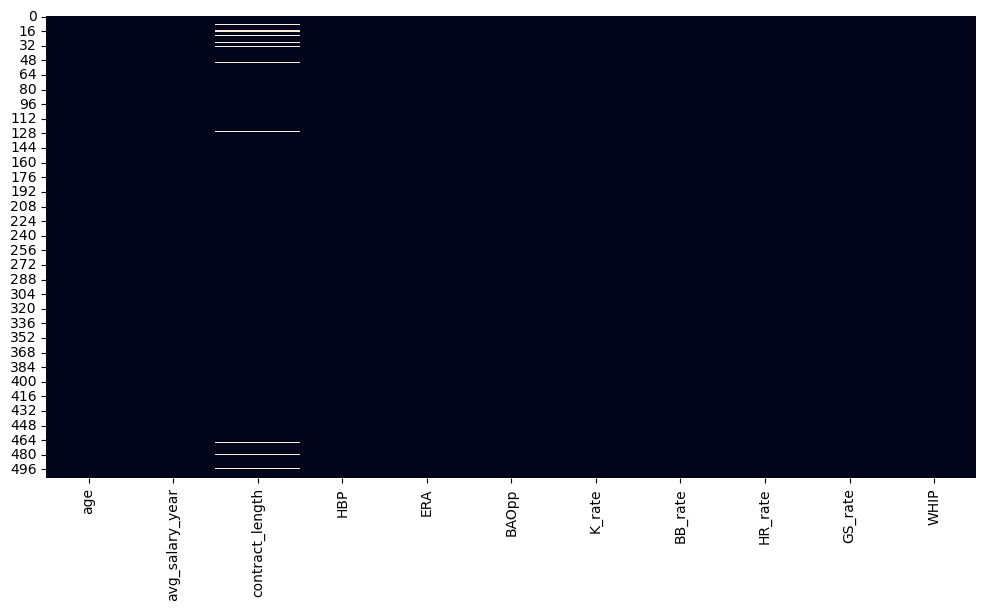

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False)
plt.show()

Barely any data is missing so we are safe to drop na.

In [9]:
X = X.dropna()
Xorig = X.copy()
X = X.drop(columns=['avg_salary_year', 'contract_length'])

In [10]:
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

k = 4 looks to be optimal based on elbow, look at sihouette score next

In [11]:
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

Looks like 2 clusters is best

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



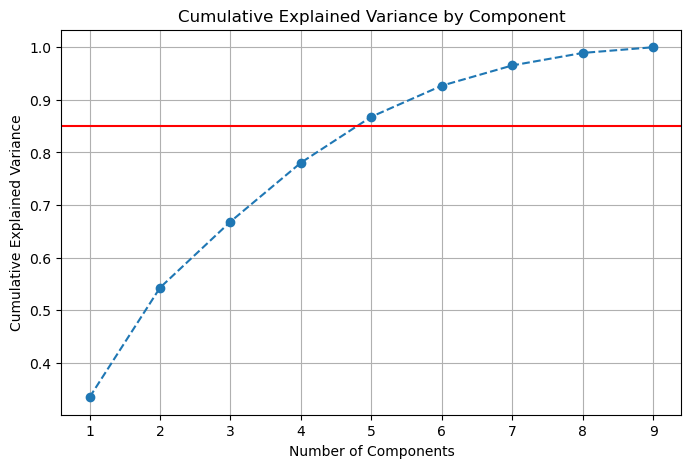

In [12]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
pca = pipe["pca"]

# cumulative explained variance plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='-') # Threshold line at 90%
plt.grid()
plt.show()

In [13]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5, random_state=6021)),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
labels = pipe["kmeans"].labels_

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



### Principal Direction Contributions

PC1 is a perfomance based axis for power and onbase ability (higher PC1 is better hitter), PC2 is essentially just age (higher PC2 is older), PC3 is a AVG vs SLG contrast (higher PC3 is better SLG but worse AVG stats).

In [14]:
pca_loadings = pd.DataFrame(
    pipe["pca"].components_.T, 
    index=X.columns, 
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)
pca_loadings


,PC1,PC2,PC3,PC4,PC5
age,-0.150550,-0.245651,0.581834,-0.060138,0.716630
HBP,0.170446,-0.412054,-0.402963,-0.493465,0.251941
ERA,0.474976,0.169374,-0.039723,0.167474,0.042144
BAOpp,0.495469,0.038369,0.297517,-0.039913,-0.185414
K_rate,-0.389576,0.220007,-0.366219,0.085668,0.082201
BB_rate,0.043128,0.559476,-0.299394,-0.293291,0.450352
HR_rate,0.200094,-0.123591,-0.281890,0.773944,0.389208
GS_rate,0.256162,-0.509005,-0.316274,-0.088292,-0.012384
WHIP,0.466803,0.322381,0.075836,-0.151960,0.160006


### Principal Component Scores

In [15]:
X_pca = pipe[:-1].transform(X) # Exclude the KMeans step to get PCA-transformed data
pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=X.index)

,PC1,PC2,PC3,PC4,PC5
0,2.659708,0.903791,-0.224487,0.167999,1.882747
1,0.304972,2.424270,-1.300223,2.097670,1.485203
2,8.521356,3.641353,0.954952,3.340757,0.273557
3,-0.373648,-0.182750,-0.039592,0.083053,-0.036244
4,0.089287,-1.004963,-0.586800,-1.819174,-0.079481
...,...,...,...,...,...
501,-0.932607,-0.853696,0.046882,1.383444,0.926455
502,0.146463,-2.197077,-1.970761,-0.735618,-0.197964
503,-0.635832,-2.412312,-1.151991,-0.396697,-1.468421
504,-2.181633,-2.085849,-0.847473,-0.400845,-1.001257


### PC Contribution to Variance Explanation

In [16]:
eigenvalues = pipe["pca"].explained_variance_
variance_ratios = pipe["pca"].explained_variance_ratio_
cumulative_variance = variance_ratios.cumsum()

import pandas as pd

pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Variance Proportion': variance_ratios,
    'Cumulative Variance': cumulative_variance
}, index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])


,Eigenvalue,Variance Proportion,Cumulative Variance
PC1,3.019441,0.334816,0.334816
PC2,1.877663,0.208208,0.543023
PC3,1.131736,0.125494,0.668518
PC4,1.010540,0.112055,0.780573
PC5,0.787676,0.087343,0.867916


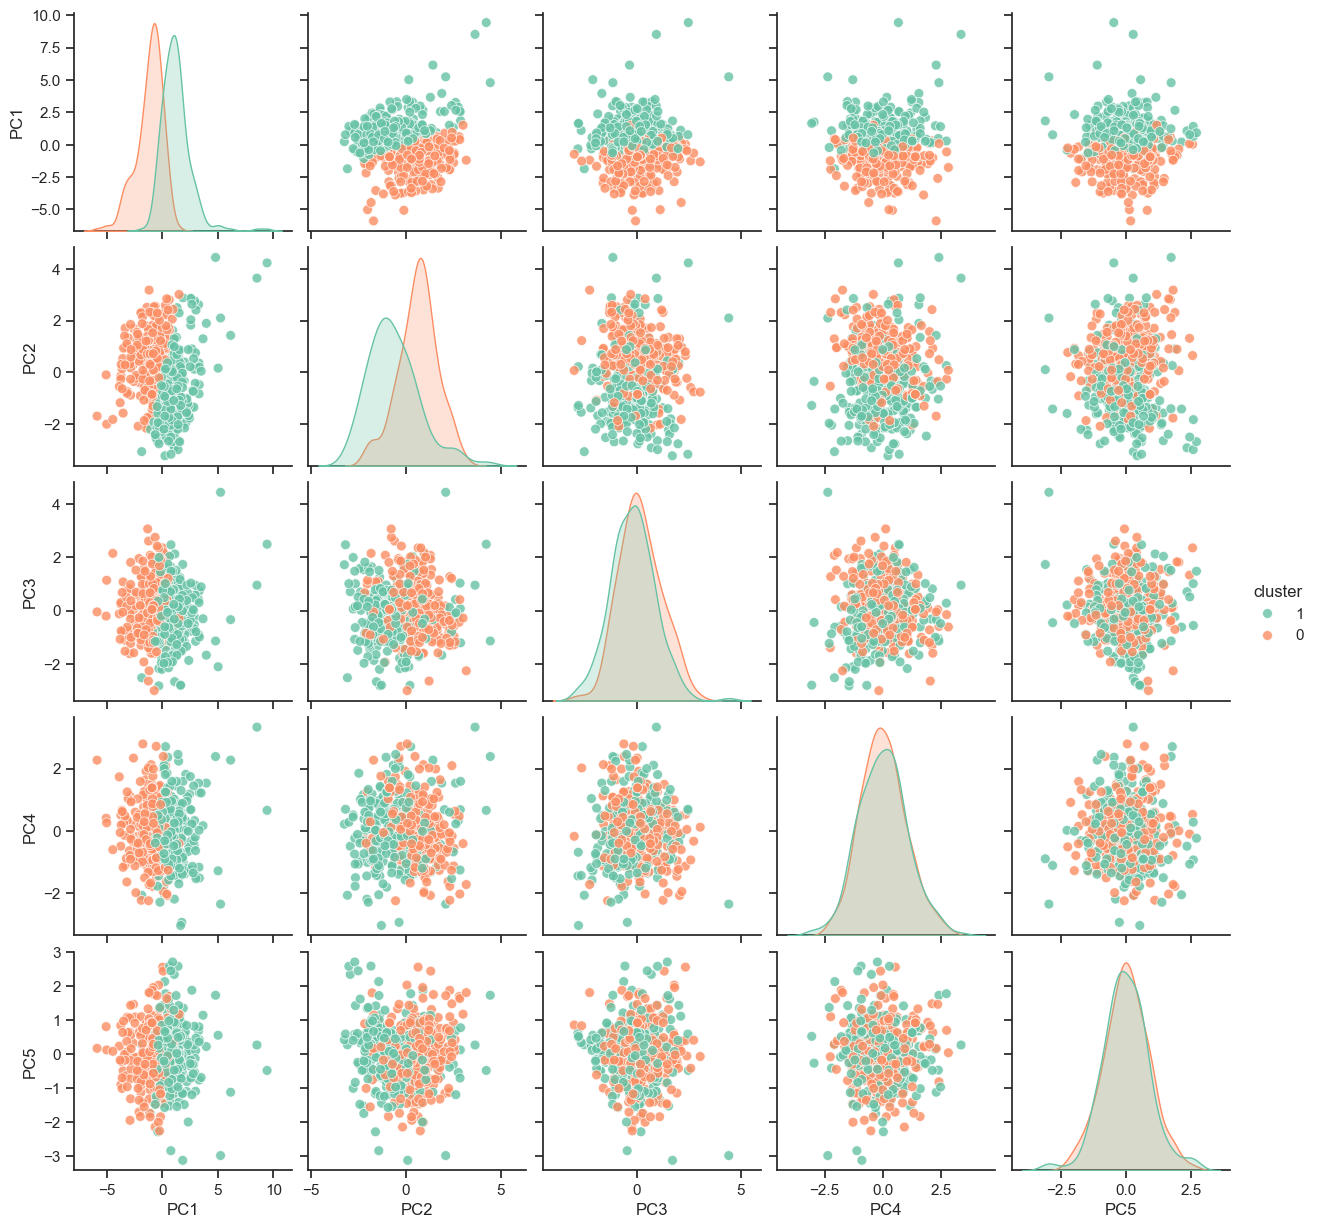

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

X_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_plot['cluster'] = labels.astype(str)
cluster_labels = X_plot['cluster'].unique()

# Biplot (Using RAW Loadings and Scores)
fig = go.Figure()

# Scatter Plot by cluster for color mapping
for label in cluster_labels:
    df_cluster = X_plot[X_plot['cluster'] == label]
    fig.add_trace(go.Scatter(
        x=df_cluster['PC1'], # Uses raw PC1 score
        y=df_cluster['PC2'], # Uses raw PC2 score
        mode='markers+text',
        text=df_cluster['cluster'],
        textposition='top center',
        marker=dict(size=8, opacity=0.7),
        name=f'Cluster {label}'
    ))


# Loadings (Arrows) - Uses raw loadings
loading_df_raw = pd.DataFrame({
    'var': pca_loadings.index,
    'PC1_raw': pca_loadings['PC1'], 
    'PC2_raw': pca_loadings['PC2']
})

for i, row in loading_df_raw.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, row['PC1_raw'] * 8], 
        y=[0, row['PC2_raw'] * 8],
        mode='lines+markers+text',
        text=[None, row["var"]],
        textposition='top center',
        line=dict(color='red', width=2),
        marker=dict(size=5, color='red'),
        showlegend=False,
        textfont=dict(color='red', size=12)
    ))

fig.update_layout(
    title='PCA Biplot with RAW Loadings (Recommended)',
    xaxis_title='PC1',
    yaxis_title='PC2',
    height=600,
    width=800
)
fig.show()

sns.set(style="ticks")
pair_plot = sns.pairplot(
    X_plot, 
    hue='cluster', 
    palette='Set2', 
    diag_kind='kde',
    plot_kws={'alpha': 0.8, 's': 50})

plt.show()

Best separation we can see is along PC1 and PC2

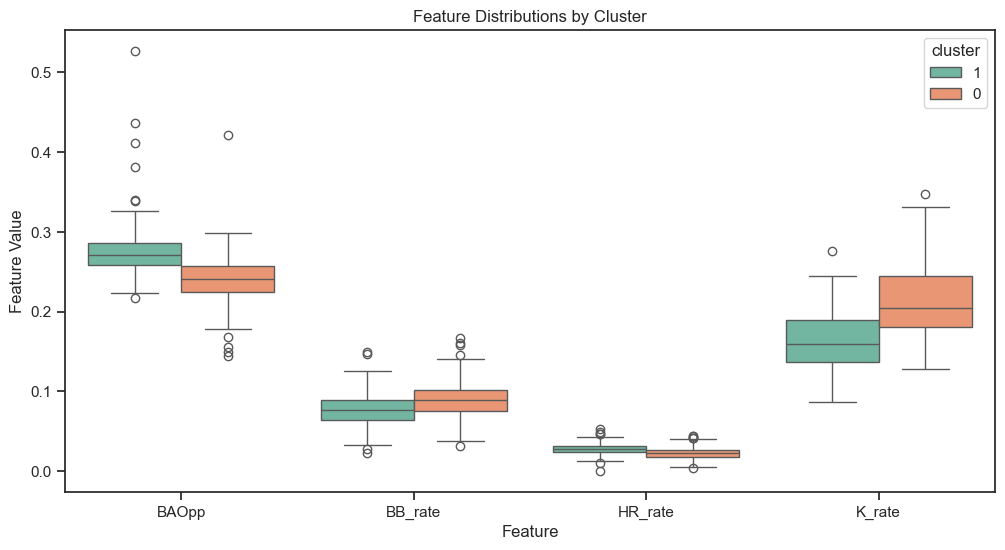

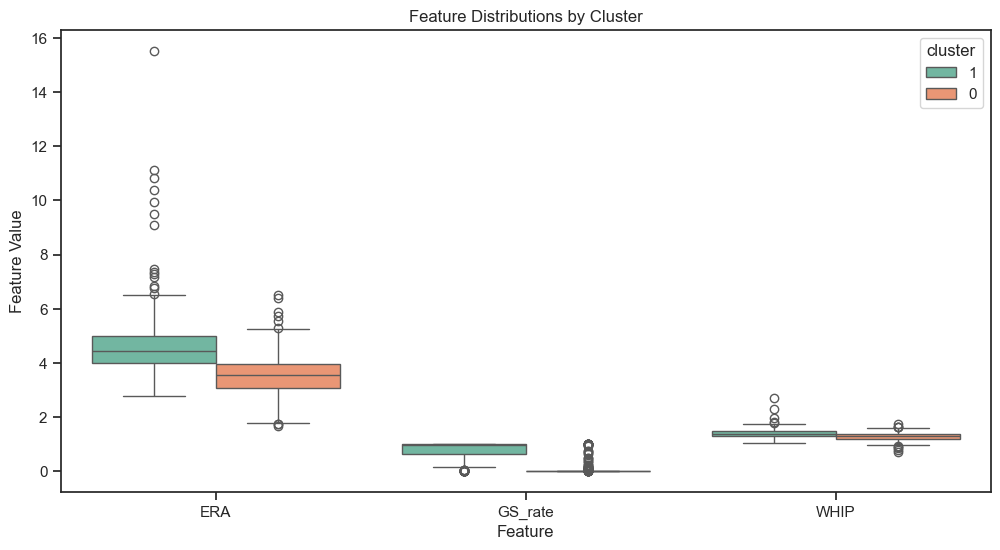

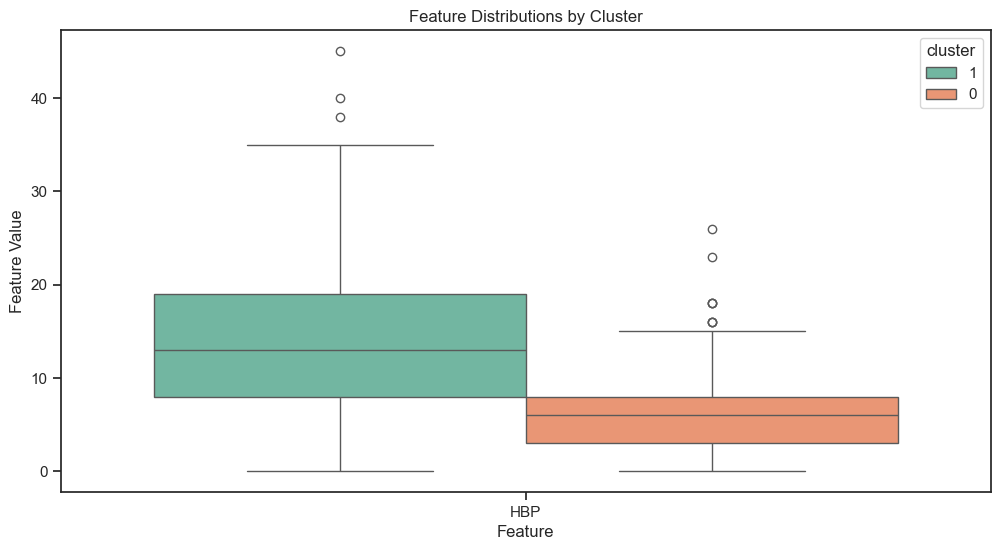

In [18]:
X['cluster'] = labels.astype(str)
X2 = X.drop(columns=['HBP', 'ERA', 'GS_rate', 'WHIP'])
plot_df = X2.melt(id_vars='cluster', value_vars=X2.columns.difference(['cluster', 'age']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.show()

X3 = X.drop(columns=['BAOpp', 'BB_rate', 'HR_rate', 'K_rate', 'HBP'])
plot_df = X3.melt(id_vars='cluster', value_vars=X3.columns.difference(['cluster', 'age']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.show()

X4 = X[['HBP', 'cluster', 'age']]
plot_df = X4.melt(id_vars='cluster', value_vars=X4.columns.difference(['cluster', 'age']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.show()

### Salary and Contract Length Comparisons Across Clusters

In [19]:
Xorig['cluster'] = labels.astype(str)
Xorig.groupby('cluster')[['avg_salary_year', 'contract_length']].agg(['mean','median','std', 'count'])

avg_salary_year                                    contract_length  \
                   mean        median            std count            mean   
cluster                                                                      
0          3.289426e+06  3.278747e+06  554003.496859   250        1.636000   
1          3.204838e+06  3.136517e+06  562457.976679   245        1.604082   

                                
        median       std count  
cluster                         
0          1.0  1.025530   250  
1          1.0  1.109933   245

In [20]:
fig_salary = px.box(
    Xorig, 
    x='cluster', 
    y='avg_salary_year', 
    color='cluster',
    title="Average Yearly Salary by Batter Cluster",
    labels={'avg_salary_year': 'Avg Salary per Year ($)', 'cluster': 'Batter Segment'},
)
fig_salary.show()

fig_len = px.box(
    Xorig, 
    x='cluster', 
    y='contract_length', 
    color='cluster',
    title="Contract Length by Batter Cluster",
    labels={'contract_length': 'Years of Contract', 'cluster': 'Batter Segment'},
)
fig_len.show()

### Is this significant difference?

In [21]:
from scipy import stats

cluster_0_salary = Xorig[Xorig['cluster'] == '0']['avg_salary_year']
cluster_1_salary = Xorig[Xorig['cluster'] == '1']['avg_salary_year']

t_stat, p_val = stats.ttest_ind(cluster_0_salary, cluster_1_salary, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market values these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful pay difference.")

cluster_0_contract = Xorig[Xorig['cluster'] == '0']['contract_length']
cluster_1_contract = Xorig[Xorig['cluster'] == '1']['contract_length']

t_stat, p_val = stats.ttest_ind(cluster_0_contract, cluster_1_contract, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant. The market contracts these player segments differently.")
else:
    print("Result: Not significant. The clusters do not represent a meaningful contract length difference.")

T-statistic: 1.6854
P-value: 9.2546e-02
Result: Not significant. The clusters do not represent a meaningful pay difference.
T-statistic: 0.3321
P-value: 7.3993e-01
Result: Not significant. The clusters do not represent a meaningful contract length difference.
